In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Background

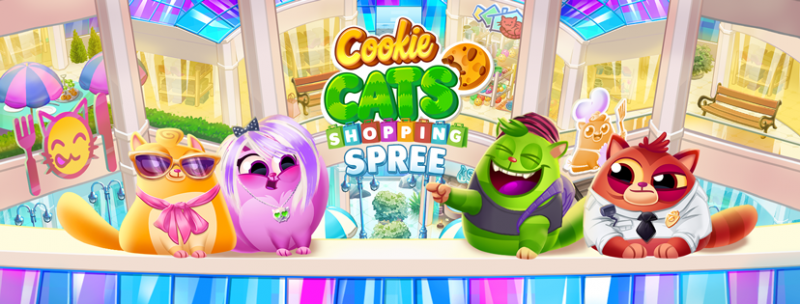

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats.

As players progress through the game, they would encounter gates that ask them to wait some amount of time to enter the next game or make purchases to avoid waiting. As a result, the timing of placing gates is an important decision to make.

# Goals

In this project, we will analyze the result of an experiment where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

# Data Descriptions

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- userid - a unique number for each player.
- version - whether the player was put in the control group
- sum_gamerounds - the number of game rounds played by the player during the 14 days after installation
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

# Process

1. Understanding the data
2. Preparation to AB testing
3. AB testing with z-test and bootstrapping
4. Conclusions

# Understand the data

In [2]:
df = pd.read_csv('cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [3]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [4]:
df.shape

(90189, 5)

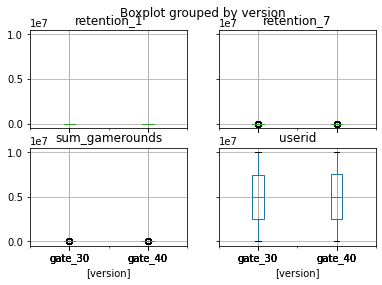

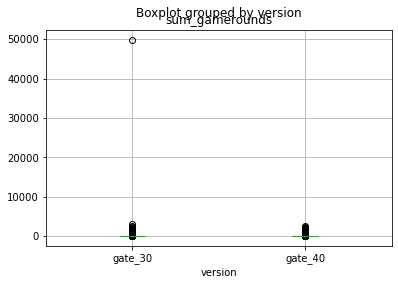

In [5]:
df.boxplot(by='version')
df.boxplot(column='sum_gamerounds', by='version')
plt.show()

In [6]:
df_no_outlier = df[df.sum_gamerounds < df.sum_gamerounds.max()]
df_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90188 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90188 non-null  int64 
 1   version         90188 non-null  object
 2   sum_gamerounds  90188 non-null  int64 
 3   retention_1     90188 non-null  bool  
 4   retention_7     90188 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.9+ MB


# Peparation to AB testing

- A: first gate 30
- B: first gate 40

In [7]:
# number of player in each AB group 
df_no_outlier.groupby('version')['userid'].count()

version
gate_30    44699
gate_40    45489
Name: userid, dtype: int64

It looks like there is roughly the same number of players in each group

Text(0, 0.5, 'User Count')

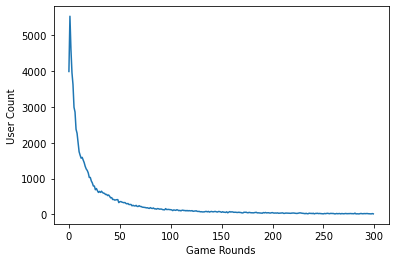

In [8]:
#distribtion of user for sum game round
game_count = df_no_outlier.groupby('sum_gamerounds')['userid'].count()
ax = game_count.head(n=300).plot(x="sum_gamerounds", y="userid")
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!

In [9]:
df_no_outlier.groupby('sum_gamerounds')['userid'].count().head(5)

sum_gamerounds
0    3994
1    5538
2    4606
3    3958
4    3629
Name: userid, dtype: int64

There are around 4000 users downloaded the app but neverplay the game.

#### Retention rate

In [10]:
rentation_1_rate = df_no_outlier['retention_1'].sum() / df_no_outlier['retention_1'].count()
rentation_1_rate = '{:.1%}'.format(rentation_1_rate)
print('Rentation day 1 rate: {}'.format(rentation_1_rate))

Rentation day 1 rate: 44.5%


In [11]:
rentation_7_rate = df_no_outlier['retention_7'].sum() / df_no_outlier['retention_7'].count()
rentation_7_rate = '{:.1%}'.format(rentation_7_rate)
print('Rentation day 7 rate: {}'.format(rentation_7_rate))

Rentation day 7 rate: 18.6%


In [12]:
pd.DataFrame({"day1_ratio": df_no_outlier.groupby('version')['retention_1'].sum() / df_no_outlier.groupby('version')['retention_1'].count(),
              "day7_ratio": df_no_outlier.groupby('version')['retention_7'].sum() / df_no_outlier.groupby('version')['retention_1'].count()})

,day1_ratio,day7_ratio
version,,
gate_30,0.448198,0.190183
gate_40,0.442283,0.182000


For gate 30, both day1 and day7 retention rate are slighly higher than gate 40. 

#### Game rounds rate 

In [13]:
pd.DataFrame({"game round per user": df_no_outlier.groupby('version')['sum_gamerounds'].sum() / df_no_outlier.groupby('version')['sum_gamerounds'].count()})

,game round per user
version,
gate_30,51.342111
gate_40,51.298776


For gate 30, game round per user is slighly higher than gate 40.

## Normality test

In [89]:
from scipy.stats import kstest

In [92]:
print('Normality retention_1:', kstest(df['retention_1'], 'norm'))
print('Normality retention_7:', kstest(df['retention_7'], 'norm'))
print('Normality sum_gamerounds:', kstest(df['sum_gamerounds'], 'norm'))

Normality retention_1: KstestResult(statistic=0.5, pvalue=0.0)
Normality retention_7: KstestResult(statistic=0.5, pvalue=0.0)
Normality sum_gamerounds: KstestResult(statistic=0.8715607041848303, pvalue=0.0)


Karena pvalue < alpha, H0 ditolak artinya ketiga data tersebut masing-masing tidak normal 

# AB testing

Perform AB testing to see if there is a difference between two version.
- A: first gate 30
- B: first gate 40

Hypothesis

- H0: There is no difference effect between gate 30 and gate 40 version (a=b).
- H1: There is a difference effect between two version (a!=b).

Use rentation mean and game rounds rate as test statistic.

Bootstrap : resampling with replacement

Objective : to make other sample from original data --> membuat hasil uji lebih meyakinkan tanpa perlu mengeluarkan biaya lebih untuk melakukan penelitian kembali.

In [47]:
def ab_mannwhitney(a,b,hyphotesis='two-sided'):
    from scipy.stats import mannwhitneyu as mannwhitneyu
    ttest=mannwhitneyu(a, b, alternative=hyphotesis)
    
    return ttest

def ab_chisquare(data):
    from scipy.stats import chi2_contingency
    test=chi2_contingency(data)
    
    return test[0:3]

def bootstrap (data, Nboot, statfun):
    '''Calculate bootstrap for a sample data'''
    data=np.array(data) #supaya bisa di-index
    
    resample_stat=[]
    for i in range(Nboot):
        index=np.random.randint(0,len(data),len(data))
        sample=data[index]
        resample_stat.append(statfun(sample))
    
    return np.array(resample_stat)

def bootstrap_diff (a,b, Nboot, statfun=np.mean):
    '''Calculate different statfun between 2 bootstrap datasets, return in array'''
    bs_a = bootstrap(a,Nboot,statfun)
    bs_b = bootstrap(b,Nboot,statfun)
    
    bs_diff = bs_a - bs_b
    
    return bs_diff

## > Retention 1 day 

In [15]:
gate_30_ren_1 = df_no_outlier[df_no_outlier['version']=='gate_30']['retention_1']
gate_40_ren_1 = df_no_outlier[df_no_outlier['version']=='gate_40']['retention_1']
mean_diff_1 = gate_30_ren_1.mean() - gate_40_ren_1.mean()
print('difference of means=', str(mean_diff_1))

difference of means= 0.005915196587034155


Perbedaan mean antara gate 30 dan 40 untuk retention 1 day dataset asli sebesar 0.6%. Selanjutnya akan diuji secara statistik menggunakan 2-sample z-test

In [76]:
cross_1=pd.crosstab(df_no_outlier["version"], df_no_outlier["retention_1"])
ab_chisquare(cross_1)

(3.169835543170799, 0.07500999897705693, 1)

Karena p-value > 0.05 maka H0 tidak ditolak, artinya secara statistik tidak ada perbedaan efek pada retention 1 day antara first date 30 dan 40.

**Non parametric, maka untuk CI dilakukan dengan bootstrap**

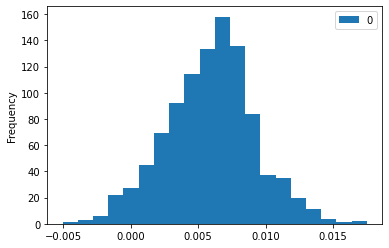

In [70]:
#bootstrapping
boot_1d=bootstrap_diff(gate_30_ren_1, gate_40_ren_1, 1000)
ax = pd.DataFrame(boot_1d).plot.hist(bins=20)

Perbedaan rata-rata paling banyak sekitar sekitar 0,5%-1%. Dan mayoritas perbedaannya diatas 0% yang artinya gate 30 lebih besar.

In [71]:
mean_diff_bs_1=np.mean(boot_1d)
print('difference of means=', str(mean_diff_bs_1))

difference of means= 0.005937864504508845


Selisih gate 30 dan 40 antara data asli dan data bootstrap hampir sama

In [73]:
### probability gate 30 have retention rate higher than gate 40 (diff>0)
prob_1d = (boot_1d > 0).sum() / len(boot_1d)
prob_1d = '{:.1%}'.format(prob_1d)
print('probability of difference day1',prob_1d)

probability of difference day1 95.6%


The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30

In [74]:
conf_int_1d = np.percentile(boot_1d,[2.5, 97.5])
print('95% confidence interval=',conf_int_1d)

95% confidence interval= [-0.00074548  0.01266702]


MDE = 0.02/0.44 = 0.04
Karena melewati 0, maka H0 tidak ditolak, artinya secara statistik tidak ada perbedaan antara first gate 30 dan 40 untuk retention 1 day. Dan karena minimal CI dibawah MDE, dikatakan belum practical significance

## > Retention 7 day

In [75]:
gate_30_ren_7 = df_no_outlier[df_no_outlier['version']=='gate_30']['retention_7']
gate_40_ren_7 = df_no_outlier[df_no_outlier['version']=='gate_40']['retention_7']
mean_diff_7 = gate_30_ren_7.mean() - gate_40_ren_7.mean()
print('difference of means=', str(mean_diff_7))

difference of means= 0.00818318160884296


In [77]:
cross_7=pd.crosstab(df_no_outlier["version"], df_no_outlier["retention_7"])
ab_chisquare(cross_7)

(9.91527552890567, 0.0016391259678654425, 1)

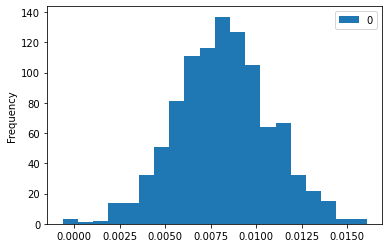

In [78]:
boot_7d=bootstrap_diff(gate_30_ren_7, gate_40_ren_7, 1000)
ax = pd.DataFrame(boot_7d).plot.hist(bins=20)

Perbedaan rata-rata diatas 0, jd memang kemungkinan besar untuk retention 1 day lbh baik first gate 30

In [79]:
mean_diff_bs_7=np.mean(boot_7d)
print('difference of means=', str(mean_diff_bs_7))

difference of means= 0.008207452304297707


In [80]:
### probability gate 30 have retention rate higher than gate 40 (diff>0)
pvalue_7d = (boot_7d > 0).sum() / len(boot_7d)
prob_7d = '{:.1%}'.format(pvalue_7d)
print('pvalue',pvalue_7d)
print('probability of difference day1',prob_7d)

pvalue 0.997
probability of difference day1 99.7%


In [81]:
conf_int_7d = np.percentile(boot_7d,[2.5, 97.5])
print('95% confidence interval=',conf_int_7d)

95% confidence interval= [0.00308988 0.01344182]


MDE = 0.02/0.19 =0.105
Karena melewati 0, maka H0 tidak ditolak, artinya secara statistik tidak ada perbedaan antara first gate 30 dan 40 untuk retention 1 day. Dan karena minimal CI dibawah MDE, dikatakan belum practical significance

## > Game rounds

In [82]:
gate_30_rounds = df_no_outlier[df_no_outlier['version']=='gate_30']['sum_gamerounds']
gate_40_rounds = df_no_outlier[df_no_outlier['version']=='gate_40']['sum_gamerounds']
mean_diff_gr = gate_30_rounds.mean() - gate_40_rounds.mean()
print('difference of means=', str(mean_diff_gr))

difference of means= 0.04333503360787461


In [84]:
cross_gr=pd.crosstab(df_no_outlier["version"], df_no_outlier["sum_gamerounds"])
ab_chisquare(cross_gr)

(984.4805849301695, 0.1525787675124735, 940)

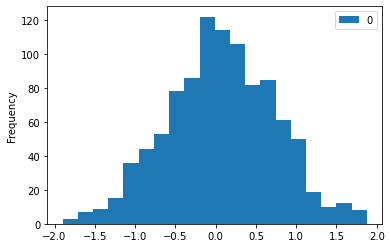

In [85]:
boot_gr=bootstrap_diff(gate_30_rounds, gate_40_rounds, 1000)
ax = pd.DataFrame(boot_gr).plot.hist(bins=20)

In [86]:
mean_diff_gr=np.mean(boot_gr)
print('difference of means=', str(mean_diff_gr))

difference of means= 0.06910888557520631


In [87]:
### probability gate 30 have retention rate higher than gate 40 (diff>0)
prob_gr = (boot_gr > 0).sum() / len(boot_gr)
prob_gr ='{:.1%}'.format(prob_gr)
print('probability of difference day1',prob_gr)

probability of difference day1 54.4%


In [88]:
conf_int_gr = np.percentile(boot_gr,[2.5, 97.5])
print('95% confidence interval=',conf_int_gr)

95% confidence interval= [-1.26543612  1.36742796]


Misal MDE=2/51=0.03

# Conclusions

1. Pada retention 1 day, perbedaan fisrt gate level 30 atau 40 tidak memberikan perbedaan secara signifikan. Namun jika dilihat melalui histogram selisih mean bootstrap datasets antara level 30 dan 40 terdapat 96% kemungkinan bahwa perbedaanya lebih dari 0% yang mengindikasikan fisrt gate level 30 lebih baik karena retention rate-nya lebih tinggi.
2. Pada retention 7 day, terdapat perbedaan yang signifikan fisrt gate level 30 atau 40. Melalui histogram selisih mean bootstrap datasets antara level 30 dan 40  menunjukkan 100% perbedaan lebih dari 0% artinya first gate 30 lebih baik.
3. Untuk game rounds, tidak ada perbedaan efek antara fisrt gate level 30 atau 40

Saran
- The company should not move to gate 40 since 7-day retention is higher when the gate is at level 30.
- The retention rate drops from 44% to 18% within six days. The company should figure a way to maintain their player based. It might be players get bored at day3 or day4 and decide to leave the game. To improve the retention rate for the first week, the company can provide some incentives such as free gifts are add interesting challenges, etc.